# 泰坦尼克号生存者预测

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, f_classif, chi2

In [2]:
# 加载数据集
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
# 将数据集合并
df = data_train.append(data_test)

In [3]:
# 检查数据格式
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 数据解释
* __Passengerld__:乘客ID
* __Survived__:乘客是否生还
* __Pclass__:乘客登机(1/2/3等舱位)
* __Name__:乘客姓名
* __Sex__:乘客性别
* __Age__:年龄
* __SlbSp__:堂兄弟/妹个数
* __Parch__:父母与小孩的个数
* __Ticket__:票价
* __Cabin__:客舱
* __Embarked__:登船港口

In [4]:
# 查看数据常用的统计量信息
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 异常值初始观察(主要观察一下最大与最小值)
* __Fare__:船票的平均价格32.2,中位数14,平均值比中位数大很多,说明该特征分部是严重的右偏
* __Age__:最小值为0.17,最大值为80,0.17应该是不到一岁的婴儿,80则为老人家,这些极端数据需要进一步排查
* __Slbsp__:与Parch:Silbsp最大值为8,可能是异常,但又看Parch最大值为9.这两个特征同时出现,需要进一步排查

In [5]:
# 输出df数据集的观测值
'''
1.该数据集是一个DataFrame实例
2.数据的行索引是0到1308的一组数字
3.数据集中总共有1309行观测值
4.数据集中总共有12列变量,其中Age,Cabin,Embarked,Fare,Survived,Ticket有数据缺失
5.dtypess:给出了变量数据类型的汇总情况,可以用dtype方法获取每个变量的数据类型
6.memory usage:保存数据所耗费的类型
'''
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [6]:
# 查看数据集的行列大小
f'合并后一共有{str(df.shape[0])}条数据'

'合并后一共有1309条数据'

In [7]:
# 统计各行缺失的数据量
pd.isnull(df).sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

### 数据可视化

In [8]:
# 找出特征类型少的特征,进行可视化分析
%matplotlib inline
plt.rc('font', family='SimHei', size=13)
cat_list = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
for n, i in enumerate(cat_list):
    Cabin_cat_num = df[i].value_counts().index.shape[0]
    print('{0}.{1}特征的类型数量是:{2}'.format(n+1, i, Cabin_cat_num))

1.Pclass特征的类型数量是:3
2.Name特征的类型数量是:1307
3.Sex特征的类型数量是:2
4.Age特征的类型数量是:98
5.SibSp特征的类型数量是:7
6.Parch特征的类型数量是:8
7.Ticket特征的类型数量是:929
8.Fare特征的类型数量是:281
9.Cabin特征的类型数量是:186
10.Embarked特征的类型数量是:3


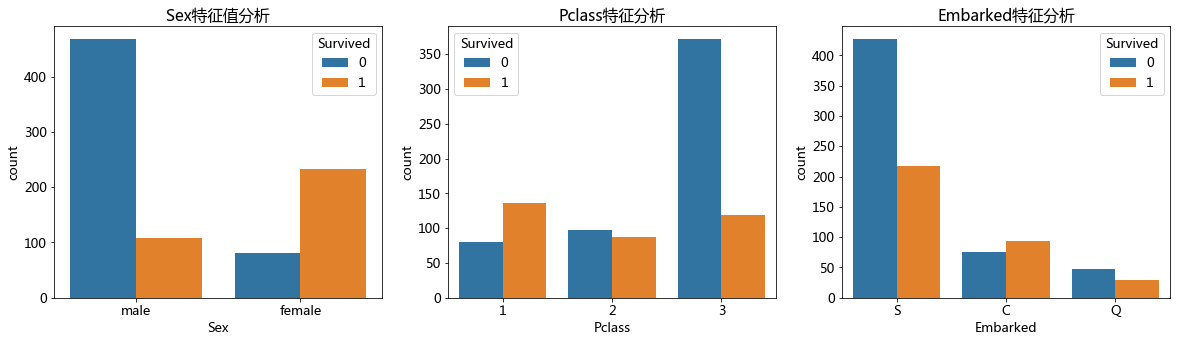

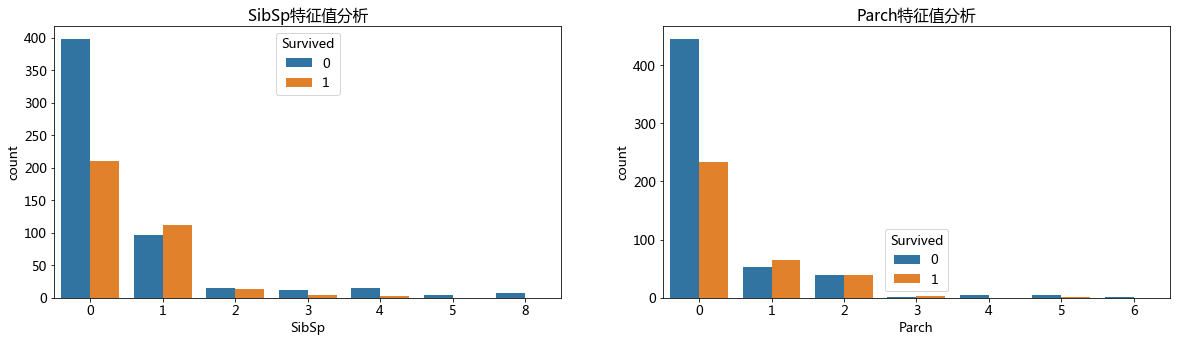

In [9]:
# 对Pclass,Sex,SibSp,Parch,Embarked五个特征进行可视化分析

# 设置中文显示字体
plt.rcParams['font.family']=['Microsoft YaHei']

f , [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20,5))
sns.countplot(x='Sex', hue='Survived', data=data_train, ax=ax1)
sns.countplot(x='Pclass', hue='Survived', data=data_train, ax=ax2)
sns.countplot(x='Embarked', hue='Survived', data=data_train, ax=ax3)
ax1.set_title('Sex特征值分析')
ax2.set_title('Pclass特征分析')
ax3.set_title('Embarked特征分析')

f, [ax1, ax2] = plt.subplots(1,2, figsize=(20,5))
sns.countplot(x='SibSp', hue='Survived', data=data_train, ax=ax1)
sns.countplot(x='Parch', hue='Survived', data=data_train, ax=ax2)
ax1.set_title('SibSp特征值分析')
ax2.set_title('Parch特征值分析')

plt.show()

#### 对上面结果进行分析
* __Sex__:男性获救比例低于女性.所以应该救援的时候女士优先
* __Pclass__:三等舱人数最多,但是获救比例最小,一等舱获救比例最高.票价反应社会地位,头等舱获救比例高
* __Embarked__:港口S上船的人最多,对应人数最多的三等舱票
* __SibSp__:大部分人是没有兄弟姐妹一起的,这种一个人的情况获救比例较低,而随着兄弟人数增加获救比例提高
* __Parch__:与SibSp同理

以上是对单独一个特征进行分析,下面分析在某些特定的特征下经过其他特征影响发的生存率,使用__FaceGrid__进行具体分析

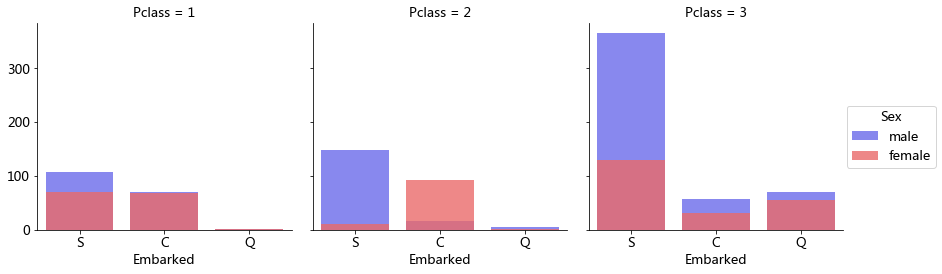

In [10]:
# 不同Pclass中男性和女性在不同港口下的数量对比
grid = sns.FacetGrid(df, col='Pclass', hue='Sex', palette='seismic', size=4)
grid.map(sns.countplot, 'Embarked', alpha=0.8)
grid.add_legend()
plt.show()

#### 结果分析
* 一等舱和二等舱的人基本上都是从S和C港上船的,而Q港的头等舱人数基本上为0,推测S和C港可能是高级港口,Q港是普通港口
* 从总体的的人数看来,在S港上船的人最多,所有S港应该是大型港口
* C港口上船的人主要性别为女性,所以C港的生还率应该很高

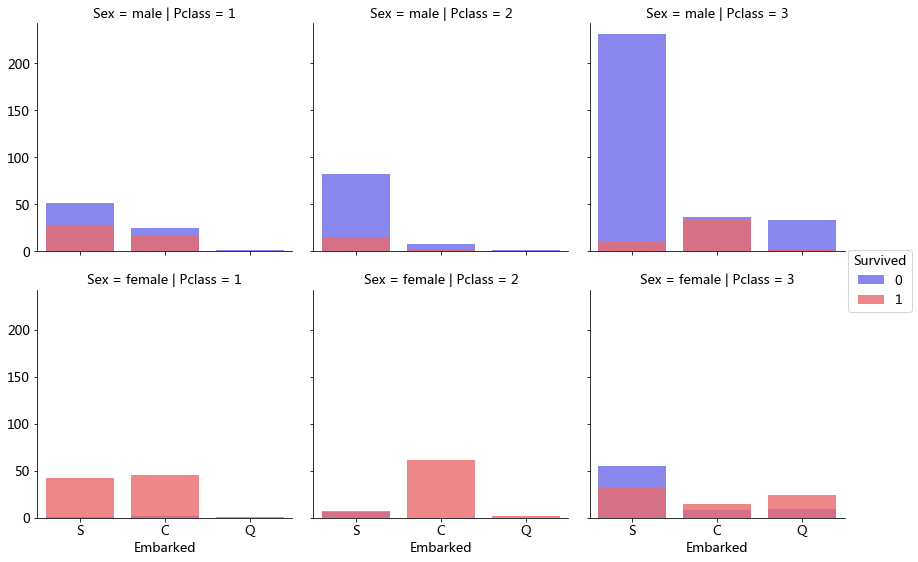

In [11]:
# 不同Pclass中,男性和女性不同港口登陆和存活对比
grid = sns.FacetGrid(data_train, col='Pclass', row='Sex', hue='Survived', palette='seismic', size=4)
grid.map(sns.countplot, 'Embarked', alpha=0.8)
grid.add_legend()
plt.show()

#### 结果分析
* 从三个港口看来,女性的存活率明显大于男性,其中一等和二等舱中的女性基本都得到了救援
* 从相同性别看来,获救率的排序是一等舱>二等舱>三等舱

### 定距/定比特征分析

__1. Age分布Survived特征分析__

/Users/pengyi/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/pengyi/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


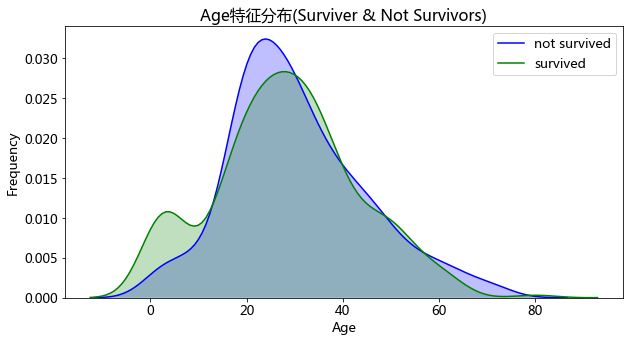

In [12]:
# kde分部
f, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(data_train.loc[(data_train['Survived']==0), 'Age'], color='b', shade=True, label='not survived')
sns.kdeplot(data_train.loc[(data_train['Survived']==1), 'Age'], color='g', shade=True, label='survived')
plt.title('Age特征分布(Surviver & Not Survivors)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()
# 忽略警告信息
warnings.filterwarnings('ignore')

__结论__:0-15岁的孩子获救率较高

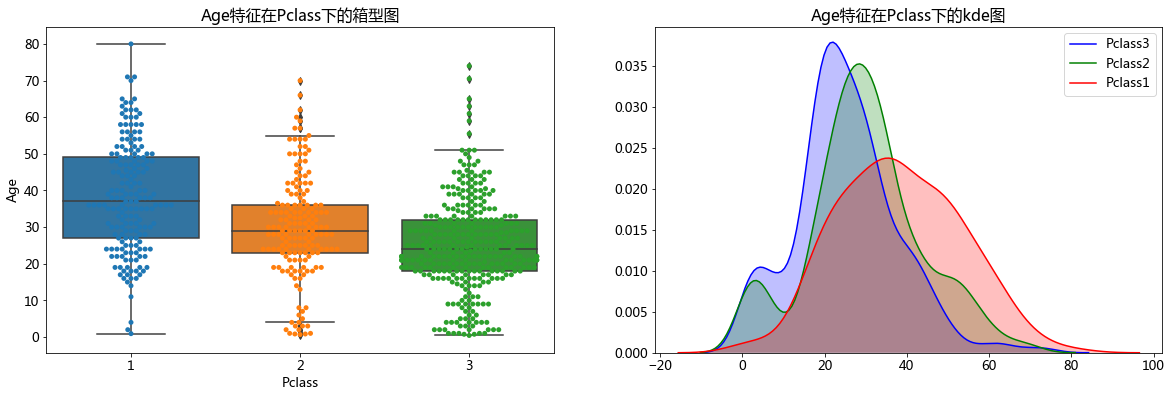

In [13]:
# 箱型图特征分析
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20,6))
sns.boxplot(x="Pclass", y="Age", data=data_train, ax=ax1)
sns.swarmplot(x='Pclass', y='Age', data=data_train, ax=ax1)
sns.kdeplot(data_train.loc[(data_train['Pclass']==3), 'Age'], color='b', shade=True, label='Pclass3', ax=ax2)
sns.kdeplot(data_train.loc[(data_train['Pclass']==2), 'Age'], color='g', shade=True, label='Pclass2', ax=ax2)
sns.kdeplot(data_train.loc[(data_train['Pclass']==1), 'Age'], color='r', shade=True, label='Pclass1', ax=ax2)
ax1.set_title('Age特征在Pclass下的箱型图')
ax2.set_title('Age特征在Pclass下的kde图')
fig.show()

__结论:__
不同Pclass下__年龄分布中位数按Pclass1>Pclass2>Pclass3__分布

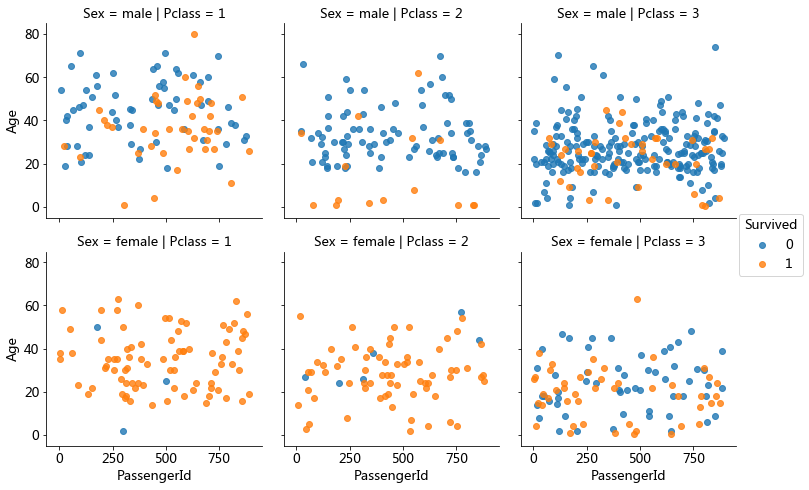

In [14]:
# Sex, Pclass分类条件下的Age年龄对Survived的散点图
grid = sns.FacetGrid(data_train, row='Sex', col='Pclass', hue='Survived', size=3.5)
grid.map(plt.scatter, 'PassengerId', 'Age', alpha=0.8)
grid.add_legend()
plt.show()

__结论__:
* Pclass1,2中存活的基本是女性(先就女性)
* Pclass2中小于15岁的人基本上都存活(先救孩童)

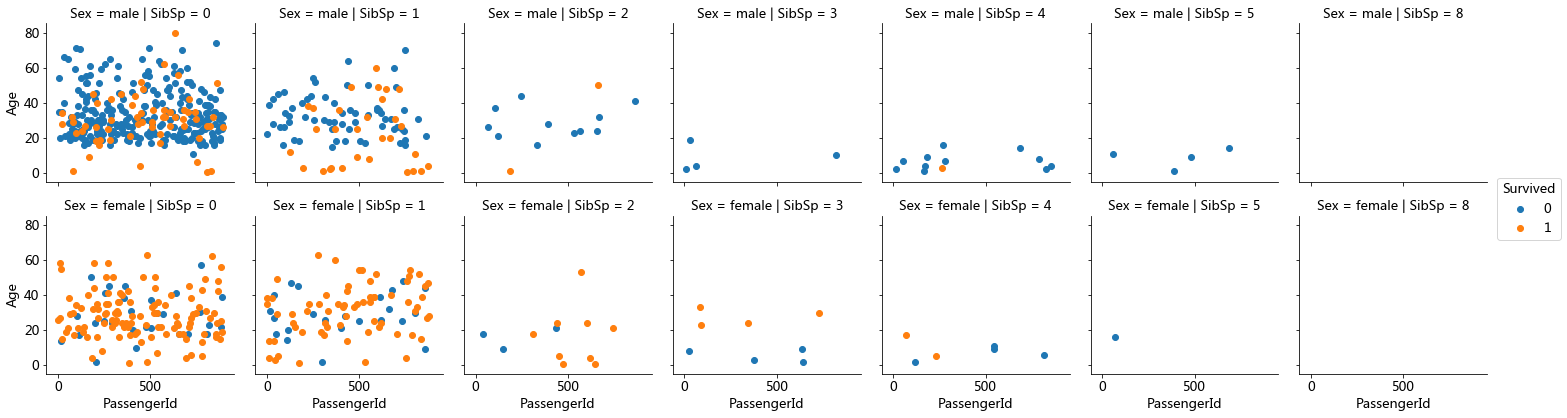

In [15]:
# Sex,SibSp分类条件下的Age年龄对Sruvived的散点图
grid = sns.FacetGrid(data_train, col="SibSp", row='Sex', hue='Survived')
grid = grid.map(plt.scatter, "PassengerId", "Age")
grid.add_legend()
plt.show()

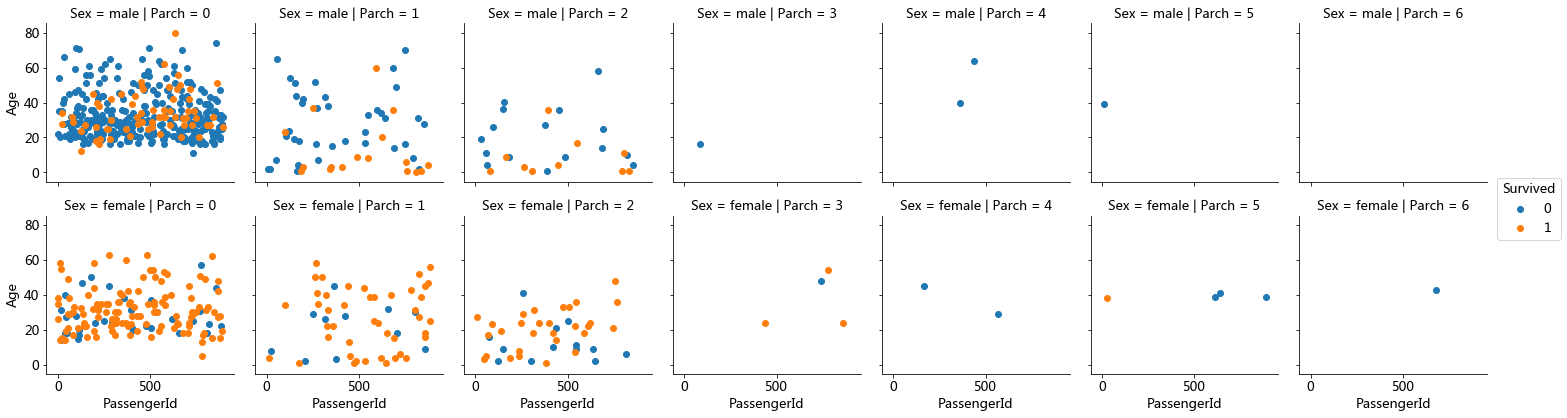

In [16]:
# Sex,Parch分类条件下Age对Survived的散点图
grid = sns.FacetGrid(data_train, col="Parch", row="Sex", hue="Survived")
grid = grid.map(plt.scatter, "PassengerId", "Age")
grid.add_legend()
plt.show()

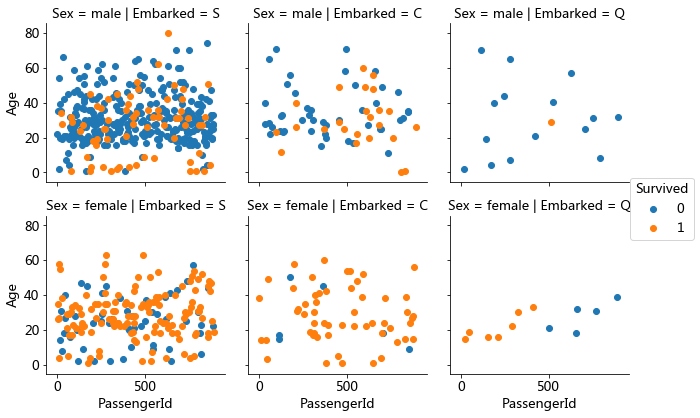

In [17]:
# Sex,Embarked分类条件下Age对Survived的散点图
grid = sns.FacetGrid(data_train, col='Embarked', row='Sex', hue='Survived')
grid = grid.map(plt.scatter, "PassengerId", 'Age')
grid.add_legend()
plt.show()

__2. Fare分布和特征分析__

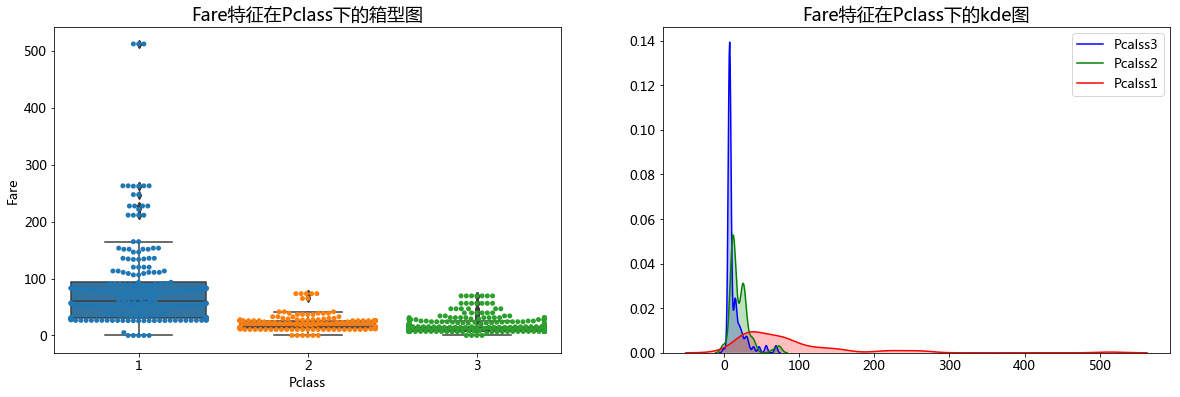

In [18]:
# 箱型图特征分析
f, [ax1, ax2] = plt.subplots(1, 2, figsize=(20,6))
sns.boxplot(x='Pclass', y='Fare', data=data_train, ax=ax1)
sns.swarmplot(x='Pclass', y='Fare', data=data_train, ax=ax1)
sns.kdeplot(data_train.loc[(data_train['Pclass']==3), 'Fare'], color='b', shade=True, label='Pcalss3', ax=ax2)
sns.kdeplot(data_train.loc[(data_train['Pclass']==2), 'Fare'], color='g', shade=True, label='Pcalss2', ax=ax2)
sns.kdeplot(data_train.loc[(data_train['Pclass']==1), 'Fare'], color='r', shade=True, label='Pcalss1', ax=ax2)
ax1.set_title('Fare特征在Pclass下的箱型图', fontsize=18)
ax2.set_title('Fare特征在Pclass下的kde图', fontsize=18)
plt.show()

__结论__:Pclass1的票价明显高于其他两个船舱,Pclass1的票价存在明显偏离的异常值,需后续拿出来单独分析

In [19]:
# 将异常票价拿出来单独观察
df.loc[df['Fare']>500]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
258,35.0,NaN,C,512.3292,"Ward, Miss. Anna",0,259,1,female,0,1.0,PC 17755
679,36.0,B51 B53 B55,C,512.3292,"Cardeza, Mr. Thomas Drake Martinez",1,680,1,male,0,1.0,PC 17755
737,35.0,B101,C,512.3292,"Lesurer, Mr. Gustave J",0,738,1,male,0,1.0,PC 17755
343,58.0,B51 B53 B55,C,512.3292,"Cardeza, Mrs. James Warburton Martinez (Charlo...",1,1235,1,female,0,NaN,PC 17755


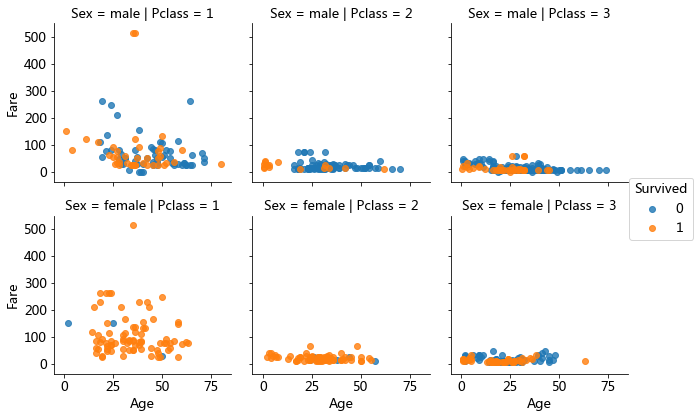

In [20]:
# Sex和Pclass分类下的Fare和Age的散点图
grid = sns.FacetGrid(data_train, row='Sex', col='Pclass', hue='Survived', size=3)
grid.map(plt.scatter, 'Age', 'Fare', alpha=0.8)
grid.add_legend()
plt.show()

#### 对上述相关特征两两关联图进行汇总,对角线表示的是自身的kde分布

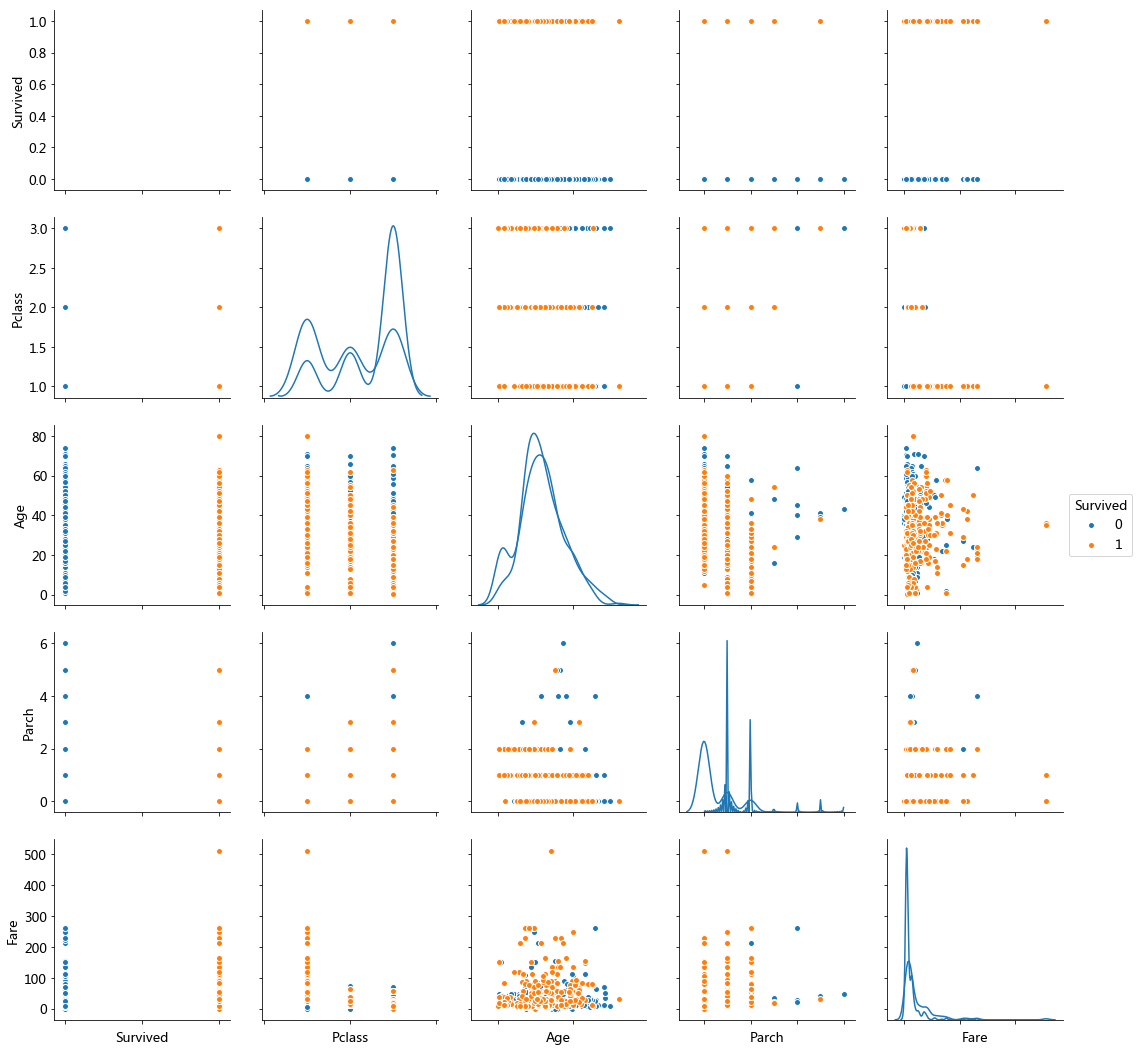

In [21]:
g = sns.pairplot(data_train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked']], hue='Survived',
                size=3, diag_kind='kde')
g.set(xticklabels=[])
plt.show()

### 数据预处理

__1. 数据清洗__

对数据的__缺失值,异常值__以及__数据一致性__进行处理

* 数据缺失值处理

    * Fare缺失值处理

In [22]:
# 查看Fare缺失特征
df[df['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


缺失值特征分析:女性,年龄大于60,S港一个人上船,船舱为Pclass3

In [23]:
# 查找相似特征人员
df.loc[(df['Pclass']==3)&(df['Age']>60)&(df['Sex']=='male')&(df['Embarked']=='S')]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
326,61.0,NaN,S,6.2375,"Nysveen, Mr. Johan Hansen",0,327,3,male,0,0.0,345364
851,74.0,NaN,S,7.7750,"Svensson, Mr. Johan",0,852,3,male,0,0.0,347060
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [24]:
# 使用特征替换法来填补缺失值
fare_mean_estimated = df.loc[(df['Pclass']==3)&(df['Age']>60)&(df['Sex']=='male')&
                             (df['Embarked']=='S')&(df['Name']!='Storey, Mr. Thomas')].Fare.mean()
df.loc[df['Name']=='Storey, Mr. Thomas', 'Fare'] = fare_mean_estimated
df.loc[df['Name']=='Storey, Mr. Thomas']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,NaN,S,7.00625,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


    * Embarked特征值缺失处理

In [25]:
# 观察Embarked缺失值观察
df[df['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


观察缺失数据特征:女性,Pclass等于1,票价80,且存活  
根据之前的可视化结果,符合这些特征的女性大部分是在__C港__口上船的

In [26]:
# 使用C港来填充数据
df['Embarked'] = df['Embarked'].fillna('C')

    * Cabin特征缺失值
Caibin只有295条数据,有大量飞缺失值,如果对该特征进行填充会产生大量的噪音.所以可以__将缺失值视为一种特殊的值__来处理,并根据Cabin首个字符衍生一个新的特征CabinCat

In [27]:
df['CabinCat'] = pd.Categorical.from_array(df.Cabin.fillna('0').apply(lambda x: x[0])).codes
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,CabinCat
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,3
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,3
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,0


用Categorical.form_array()将Cabin分成了九组,最后通过codes量化为数字,通过可视化观察一下分组离散化后的结果

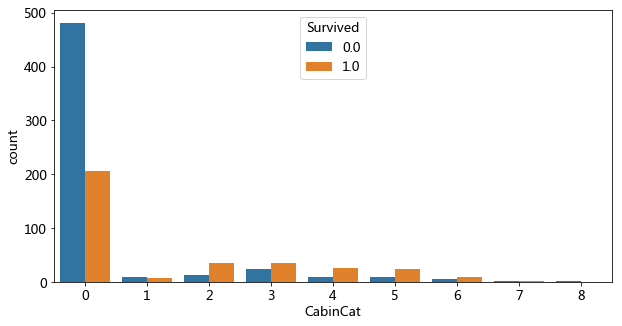

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='CabinCat', hue='Survived', data=df)
plt.show()

从以上结果看来,缺失信息的遇难人数比生存人数多得多,而不缺失Cabin信息的人群中存活的人数比较多,可以看出,Cabin数据的缺失与否与存活与否的关系比较大

    * Age特征缺失值
    Age有20%的缺失值,缺失值比较多,大量删除会减少赝本信息,由于它与Cabin不同,这里将利用其它特征进行预测填补Age,也就是拟合位置Age特征值,后续再进行处理

#### 数据一致性分析

拿到数据排除异常值之后,还要观察一下数据是否有错误信息

[错误1] :SibSp和Parch特征存在不一致

In [29]:
# 提取出Name中Surname信息
df['Surname'] = df["Name"].apply(lambda x: x.split(',')[0].lower())

In [30]:
df.loc[df['Surname']=='abbott']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,CabinCat,Surname
279,35.0,NaN,S,20.25,"Abbott, Mrs. Stanton (Rosa Hunt)",1,280,3,female,1,1.0,C.A. 2673,0,abbott
746,16.0,NaN,S,20.25,"Abbott, Mr. Rossmore Edward",1,747,3,male,1,0.0,C.A. 2673,0,abbott
392,13.0,NaN,S,20.25,"Abbott, Master. Eugene Joseph",2,1284,3,male,0,NaN,C.A. 2673,0,abbott


寻找船上姓abbott的所有人(即一家人),发现279与392号人物的SibSp与Parch信息写反了

In [31]:
# 将信息修正
df.loc[(df["Surname"]=='abbott')&(df['Age']==35), 'SibSp']=0
df.loc[(df["Surname"]=='abbott')&(df['Age']==35), 'Parch']=2
df.loc[(df["Surname"]=='abbott')&(df['Age']==13), 'SibSp']=1
df.loc[(df["Surname"]=='abbott')&(df['Age']==13), 'Parch']=1

[错误2] :SibSp和Parch特征存在不一致 

In [32]:
df.loc[df['Surname']=='ford',['Name', 'Sex', 'Age', 'SibSp', 'Parch']]

,Name,Sex,Age,SibSp,Parch
86,"Ford, Mr. William Neal",male,16.0,1,3
147,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2
436,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2
736,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3
167,"Ford, Mr. Edward Watson",male,18.0,2,2
289,"Ford, Mr. Arthur",male,NaN,0,0


In [33]:
# 修正数据
df.loc[(df['Surname']=='ford')&(df['Age']==16), 'SibSp'] = 3
df.loc[(df['Surname']=='ford')&(df['Age']==16), 'Parch'] = 1
df.loc[(df['Surname']=='ford')&(df['Age']==9), 'SibSp'] = 3
df.loc[(df['Surname']=='ford')&(df['Age']==9), 'Parch'] = 1
df.loc[(df['Surname']=='ford')&(df['Age']==21), 'SibSp'] = 3
df.loc[(df['Surname']=='ford')&(df['Age']==21), 'Parch'] = 1
df.loc[(df['Surname']=='ford')&(df['Age']==48), 'SibSp'] = 0
df.loc[(df['Surname']=='ford')&(df['Age']==48), 'Parch'] = 4
df.loc[(df['Surname']=='ford')&(df['Age']==18), 'SibSp'] = 3
df.loc[(df['Surname']=='ford')&(df['Age']==18), 'Parch'] = 1

__2.数据变换__

衍生变量

分析部分没有提及Name特征,因为每个人的名字不一样.但是一家人的surname是一样的,一家人的生存概率会非常接近
* __Title__: 从Name中提取Title信息
* __TitleCat__: 映射并量化Title信息
* __FamilySize__: 将SibSp和Parch特征进行组合
* __NameLength__: 从Name特征衍生Name长度,名字长度有可能代表社会地位
* __CabinCat__: Cabin分组信息

In [34]:
# 从Name中提取Title信息,因为同为男性,Mr.和Master.的生还率是不一样的
df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(1))
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev":6, "Major": 7, "Col": 7,
  "Mlle": 2, "Mme": 3, "Don": 9, "Dona": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}

# 量化Title信息
df["TitleCat"] = df.loc[:, "Title"].map(title_mapping)

# SibSp和Parch特征进行组合
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# 根据FamilySize分布进行分箱
df['FamilySize'] = pd.cut(df['FamilySize'], bins=[0, 1, 4, 20], labels=[0, 1, 2])

# 从Name特征衍生出Name的长度
df['NameLength'] = df['Name'].apply(lambda x:len(x))

# 量化Embarked特征
df['Embarked'] = pd.Categorical.from_array(df.Embarked).codes

# 对Sex特征进行编码分组
df = pd.concat([df, pd.get_dummies(df['Sex'])], axis=1)

高级衍生变量

1.人物特征衍生

由于儿童的生还率比较高,因此将所有的儿童乘客单独提取出来.而对于成年人女性的生还率高于男性,所有又可以分出成年女性和成年男性.

In [36]:
child_age = 18
def get_person(passenger):
    age, sex = passenger
    if (age < child_age):
        return 'child'
    elif (sex == 'female'):
        return 'female_adult'
    else:
        return 'male_adult'
    
df = pd.concat([df, pd.DataFrame(df[['Age' ,'Sex']].apply(get_person, axis=1), columns=['person'])], axis=1)
# pd.get_dummies对数据进行one-hot编码
df = pd.concat([df, pd.get_dummies(df['person'])], axis=1)

2.Ticke衍生特征

如果几个人拥有相同的ticket号码,那么意味着他们是一个小群体(一家人或者群体),而男女生还概率本生存在差异,因此将分别衍生出几个人物标签

In [44]:
table_ticket = pd.DataFrame(df['Ticket'].value_counts())
table_ticket.rename(columns={'Ticket':'Ticket_Numbers'}, inplace=True)

# 遇难成年女性
table_ticket['Ticket_dead_women'] = df.Ticket[(df.female_adult == 1)
                                             &(df.Survived == 0)
                                             &((df.Parch>0) | (df.SibSp>0))].value_counts()
table_ticket['Ticket_dead_women'] = table_ticket['Ticket_dead_women'].fillna(0)
table_ticket['Ticket_dead_women'][table_ticket['Ticket_dead_women'] > 0] = 1

# 存活成年男性
table_ticket['Ticket_surviving_men'] = df.Ticket[(df.male_adult==1)
                                                &(df.Survived==0)
                                                &(df.Parch>0)|(df.SibSp>0)].value_counts()
table_ticket['Ticket_surviving_men'] = table_ticket['Ticket_surviving_men'].fillna(0)
table_ticket['Ticket_surviving_men'][table_ticket['Ticket_surviving_men'] > 0] = 1

# Ticket特征量化
table_ticket["Ticket_Id"] = pd.Categorical.from_array(table_ticket.index).codes

table_ticket["Ticket_Id"][table_ticket["Ticket_Numbers"] < 3] = -1

# Ticket数量分箱
table_ticket["Ticket_Numbers"] = pd.cut(table_ticket["Ticket_Numbers"], bins=[0,1,4,20], labels=[0,1,2])
df = pd.merge(df, table_ticket, left_on="Ticket", right_index=True, how="left", sort=False)

同理,基于衍生变量Surname也可以衍生高级特征变量,以及Cabin的奇偶性衍生特征

In [88]:
table_surname = pd.DataFrame(df['Surname'].value_counts())
table_surname.rename(columns={'Surname':'Surname_Numbers'}, inplace=True)

# 遇难女性
table_surname['Surname_dead_women'] = df.Surname[(df.female_adult == 1)
                                                &(df.Survived == 0)
                                                &((df.Parch>0)|(df.SibSp>0))].value_counts()
table_surname['Surname_dead_women'] = table_surname['Surname_dead_women'].fillna(0)
table_surname['Surname_dead_women'][table_surname['Surname_dead_women'] > 0] = 1

# 存活男性
table_surname['Surname_surviving_men'] = df.Surname[(df.male_adult==1)
                                                &(df.Survived==0)
                                                &(df.Parch>0)|(df.SibSp>0)].value_counts()
table_surname['Surname_surviving_men'] = table_surname['Surname_surviving_men'].fillna(0)
table_surname['Surname_surviving_men'][table_surname['Surname_surviving_men'] > 0] = 1

# Surname数量分箱
table_surname["Surname_Numbers"] = pd.cut(table_surname["Surname_Numbers"], bins=[0,1,4,20], labels=[0,1,2])
df = pd.merge(df, table_surname, left_on="Surname", right_index=True, how="left", sort=False)

####  Age特征值处理

In [51]:
# 使用随机森林的ExtraTreesRegressor模型进行拟合
classers = ['Fare', 'Parch', 'Pclass', 'SibSp', 'TitleCat',
            'CabinCat', 'female', 'male', 'Embarked','FamilySize', 'NameLength', 'Ticket_Numbers', 'Ticket_Id']
etr = ExtraTreesRegressor(n_estimators=200, random_state=0)
x_train = df[classers][df['Age'].notnull()]
y_train = df['Age'][df['Age'].notnull()]
x_test = df[classers][df['Age'].isnull()]

etr.fit(x_train.as_matrix(), np.ravel(y_train))
age_preds = etr.predict(x_test.as_matrix())
df['Age'][df['Age'].isnull()] = age_preds

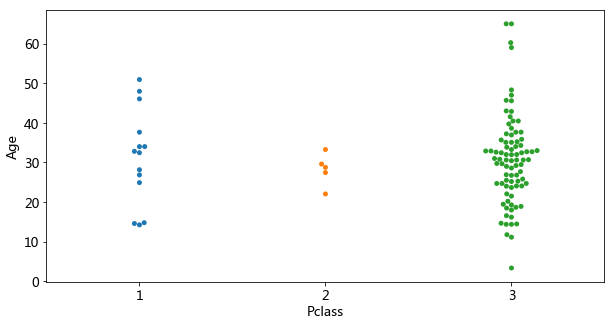

In [53]:
# 可视化观察Age拟合结果
x_test['Age'] = pd.Series(age_preds)
f, ax = plt.subplots(figsize=(10,5))
sns.swarmplot(x='Pclass', y='Age', data=x_test)
plt.show()

### 特征选择

采用方差分析的F值来对各个特征变量打分(衡量各个特征对目标变量的影响权重)

In [91]:
target = data_train['Survived'].values
features = ['female','male','Age','male_adult','female_adult', 
            'child','TitleCat','Pclass','Ticket_Id','NameLength',
            'CabinCat', 'SibSp', 'Parch','Fare','Embarked',
            'Surname_Numbers','Ticket_Numbers','FamilySize',
            'Ticket_dead_women','Ticket_surviving_men','Surname_dead_women',
            'Surname_surviving_men']
train = df[0:891].copy()
test = df[891:].copy()

selector = SelectKBest(f_classif, k=len(features))
selector.fit(train[features], target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]], features[indices[f]]))

Features importance
68.85 female
68.85 male
64.90 male_adult
53.23 female_adult
26.22 TitleCat
24.60 Pclass
23.69 NameLength
17.75 CabinCat
14.21 Fare
13.54 Ticket_dead_women
10.36 Surname_dead_women
6.78 Embarked
6.64 Ticket_surviving_men
5.27 Ticket_Numbers
3.59 child
3.42 Surname_surviving_men
2.93 FamilySize
2.02 Parch
1.66 Age
1.07 Ticket_Id
0.73 Surname_Numbers
0.61 SibSp


__分数越高权重越大__

#### 特征相关性分析

对特征相关性进行分析,相关性越大的特征越容易造成过拟合现象

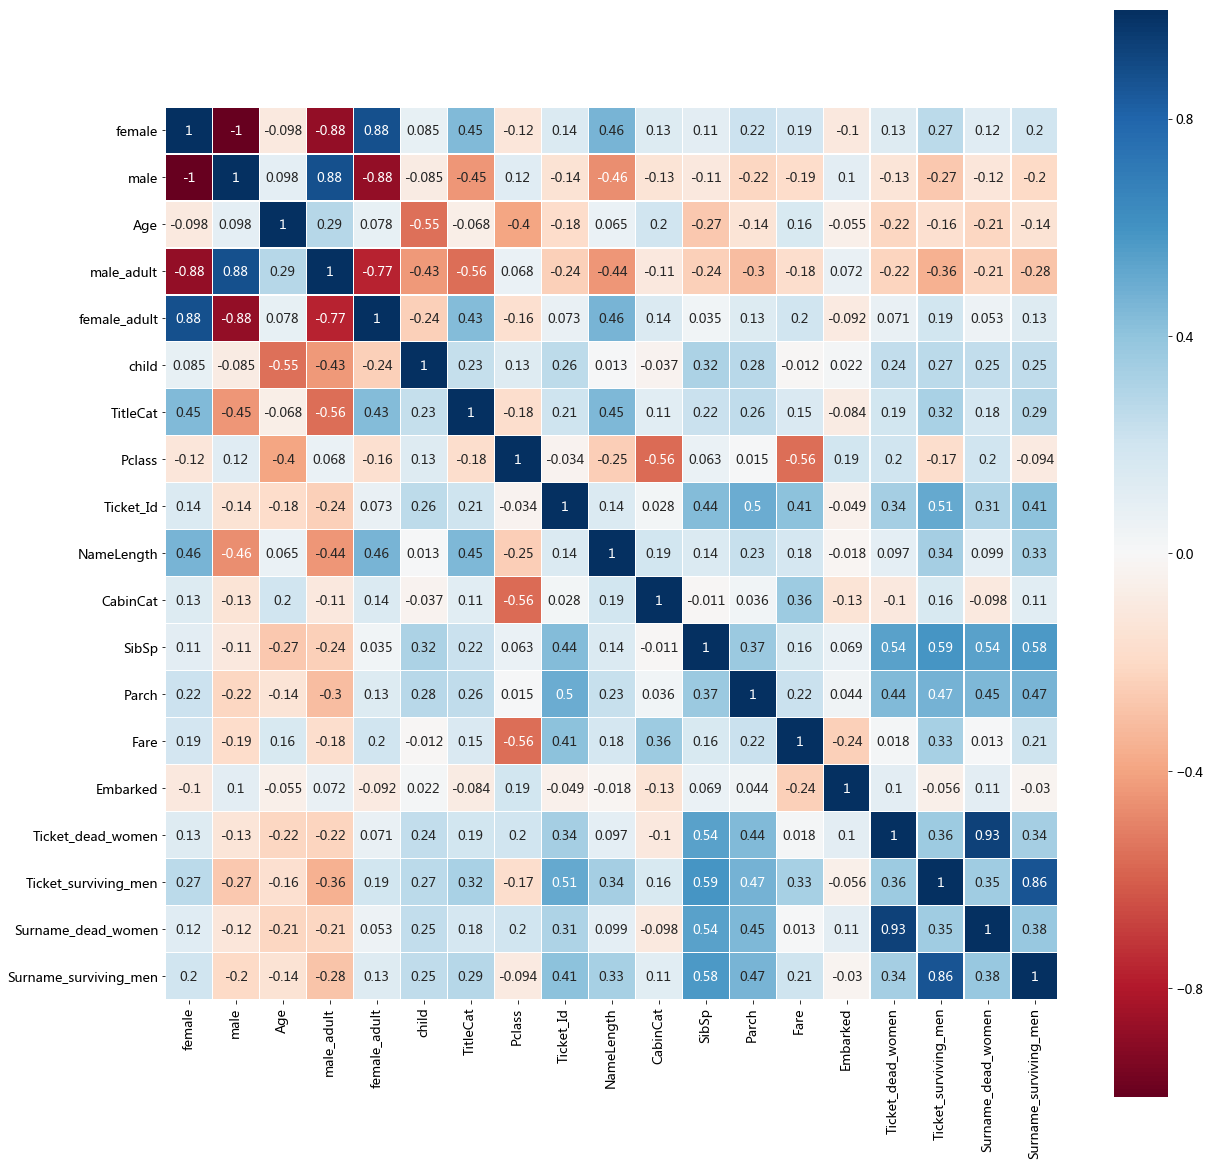

In [100]:
# 使用seaborn的heatmap展示相关性
features_selected = features
df_corr = df[features_selected].copy()

colormap = plt.cm.RdBu
plt.figure(figsize=(20,20))
# 使用DataFrame.corr()计算相关系数
sns.heatmap(df_corr.corr(), linewidth=0.1, vmax=1, square=True, cmap=colormap, 
           linecolor='white', annot=True)
plt.show()